In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [19]:
path = '/Users/somyasharma/Desktop/college_stuff/1 Pattern Recognition/HW3/Ifw'

In [20]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [21]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


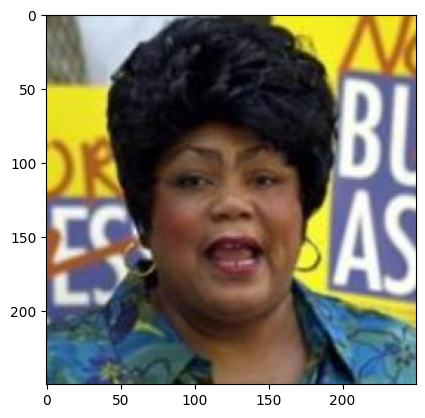

In [22]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [23]:
print("Dimensions :")
data = iter(dataloader)
image,target = next(data)
batch, channel, width, height = image.shape
print(x.shape)
print("Batch size :", batch)
print("Total channel :", channel)
print("Width of Image :", width)
print("Height of Image :", height)

print("Target :",target.shape)
print("The batch size is 32. Hence, the target is a single integer value")


Dimensions :
torch.Size([250, 250, 3])
Batch size : 32
Total channel : 3
Width of Image : 250
Height of Image : 250
Target : torch.Size([32])
The batch size is 32. Hence, the target is a single integer value


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [24]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # b, 64, 250, 250
                                 nn.BatchNorm2d(32),  # b, 64, 250, 250
                                 nn.ReLU(True),  # b, 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # b, 64, 125, 125
                                 
                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # b, 128, 125, 125
                                 nn.BatchNorm2d(64),  # b, 128, 125, 125
                                 nn.ReLU(True),  # b, 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # b, 128, 62,
                                 
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  # b, 128, 64, 64
                                 nn.BatchNorm2d(128),  # b, 128, 64, 64
                                 nn.ReLU(True),  # b, 128, 64, 64
                                 nn.MaxPool2d(2, stride=2), # b, 128, 32, 32

                                 nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # b, 256, 32, 32
                                 nn.BatchNorm2d(256),  # b, 256, 32, 32
                                 nn.ReLU(True),  # b, 256, 32, 32
                                 nn.MaxPool2d(2, stride=2) # b, 256, 16, 16
                                ) 
            

    # out =(in −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), #b, 128, 31, 31
                             nn.BatchNorm2d(128), #b, 128, 31, 31
                             
                             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 64, 62, 62
                             nn.BatchNorm2d(64), #b, 64, 62, 62
                             
                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), #b, 32, 124, 124
                             nn.BatchNorm2d(32), #b, 32, 124, 124

                             nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, output_padding=1), #b, 3, 250, 250
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [25]:
model = AE()

In [26]:
for x,y in dataloader:
    output = model.encoded_images(x)
    print(output.shape)
    decode = model.decoded_images(output)
    
    print(decode.shape)
    forward_complete = model.forward(x)
    print(forward_complete.shape)
    break;

torch.Size([32, 256, 16, 16])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters: {total_params}")

Total Number of Parameters: 777987


In [28]:
import torch.optim as optim

learning_rate = 0.001
optim = optim.Adam(model.parameters(), lr=learning_rate)


The choice of the loss function depends on the nature of the task. Since we're using an autoencoder for image reconstruction, a common choice is the Mean Squared Error (MSE) loss. It measures the average squared difference between the input and reconstructed output images. This loss function is great for tasks where you want to minimize the overall difference between the original and reconstructed images.

In [29]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [36]:
num_epochs = 330

    
for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    for x, y in dataloader:
        # Zero the gradients
        optim.zero_grad()
        
        # Forward pass
        output = model.forward(x)
        
        # Compute the loss
        loss = loss_function(output, x)
        
        # Backward pass and optimization
        loss.backward()
        optim.step()
        
        # Accumulate the loss for the epoch
        epoch_loss += loss.item()
        break;
    # Print the average loss at the end of each epoch
    average_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}")

    # Troubleshooting if the loss is not decreasing:
    # 1. Check the learning rate
    # 2. Inspect the model architecture for possible issues
    # 3. Ensure the data preprocessing is appropriate
    # 4. Experiment with different loss functions
    # 5. Monitor gradients during training to check for vanishing/exploding gradients
    # 6. Adjust the model complexity (more or fewer layers, channels, etc.)
    # 7. Increase training data if possible
    # Print the loss at the end of each epoch
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")



Epoch [1/330], Average Loss: 2.3748802138123536e-05
Epoch [2/330], Average Loss: 2.2804492787606474e-05
Epoch [3/330], Average Loss: 2.437692297541577e-05
Epoch [4/330], Average Loss: 2.4682327043175122e-05
Epoch [5/330], Average Loss: 2.3966565152297272e-05
Epoch [6/330], Average Loss: 2.3990847026380363e-05
Epoch [7/330], Average Loss: 2.060471786465046e-05
Epoch [8/330], Average Loss: 2.3240916394957023e-05
Epoch [9/330], Average Loss: 2.4813258849480303e-05
Epoch [10/330], Average Loss: 2.322836378634264e-05
Epoch [11/330], Average Loss: 2.2008425695596686e-05
Epoch [12/330], Average Loss: 2.442581291144021e-05
Epoch [13/330], Average Loss: 2.1434083113059907e-05
Epoch [14/330], Average Loss: 2.1294166518438266e-05
Epoch [15/330], Average Loss: 2.3771059397913983e-05
Epoch [16/330], Average Loss: 2.1725744548915088e-05
Epoch [17/330], Average Loss: 2.573509723092047e-05
Epoch [18/330], Average Loss: 2.1592554172887893e-05
Epoch [19/330], Average Loss: 2.3793845306991956e-05
Epoch [

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

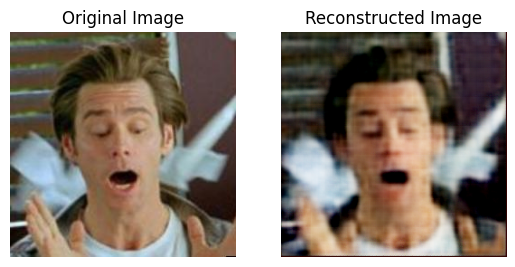

In [38]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a transform for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create an instance of ImageFolder dataset
dataset = ImageFolder(root=path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fetch a random batch of images
for images, _ in dataloader:
    # Take the first image from the batch
    image = images[0]

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

    # Encode and decode the image
    with torch.no_grad():
        output1 = model(image.unsqueeze(0))
    

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(output1.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.show()
    break  # Break after plotting the first random image


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

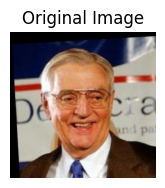

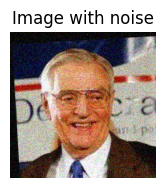

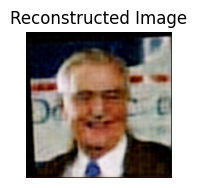

In [50]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a transform for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create an instance of ImageFolder dataset
dataset = ImageFolder(root=path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fetch a random batch of images
for images, _ in dataloader:
    # Take the first image from the batch
    image = images[11]
    
    # noise introduced
    
    noise = torch.randn_like(image) * 0.1
    output1_with_noise = image + noise

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    plt.subplot(1, 3, 2)
    plt.title('Image with noise')
    plt.imshow(output1_with_noise.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    # Encode and decode the image
    with torch.no_grad():
        output1 = model(output1_with_noise.unsqueeze(0))
    

    # Plot the reconstructed image
    plt.subplot(1, 3, 2)
    plt.title('Reconstructed Image')
    plt.imshow(output1.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.show()
    break  # Break after plotting the first random image

    
    ''''''

Adding small normally distributed noise to the latent representation 
of the input image and then decoding it can lead the autoencoder to focus more on specific features rather than achieving a generalized reconstruction.The introduced noise may disrupt the learning process, causing the model 
to emphasize particular details in the image rather than capturing the overallstructure.In essence, instead of promoting a balanced and generalized representation, the noise injection appears to be steering the autoencoder towards overemphasizing certain features, detracting from its ability to faithfully reconstruct the entire image. This observation suggests that the noise introduced at the latent level is influencing the decoding process in a way that prioritizes specific details over a holistic understanding of the input.